In [1]:
try:
    import os
    import shutil
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    ROOT = '/content/drive/My Drive/cnn/'
    if not os.path.exists(ROOT):
        os.makedirs(ROOT)
    end_dataset = '/content/drive/My Drive/Datasets/v3/data_split.zip'
    
    url="/content/tmp/" # Diretório para onde será descompactado o dataset
    if not os.path.exists(url):
        os.makedirs(url)
    shutil.unpack_archive(end_dataset, url)
    # Verifica GPU
    !nvidia-smi
except:
    ROOT = ""

Mounted at /content/drive
Thu Dec 17 18:21:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                              

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
import tensorflow as tf
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay



In [3]:
def load_features(endereco):        
    import cv2 as cv
    import numpy as np
    
    tmp = cv.imread(endereco,cv.IMREAD_GRAYSCALE)
    img = np.reshape(tmp,(tmp.shape[0],tmp.shape[1],1))
    img = img.astype('float32')
    img = img/255
    return img

def load_data(url):
    import os
    import numpy as np
    
    classes = os.listdir(url)
    x = []
    y = []
    
    for classe in classes:
        endereco = url+classe+"/"
        imgs = os.listdir(endereco)
        for img in imgs:
           x.append(load_features(endereco + img)) 
           y.append(int(classe))       
    x = np.array(x)
    y = np.array(y)    
    return x,y  


In [4]:
train_data_dir = url + '/training_set/'
test_data_dir = url + '/test_set/'

# Read dataset
X_design, Y_raw = load_data(train_data_dir)
# one_hot encode the class
Y_design = np_utils.to_categorical(Y_raw,4)
X_test, Y_raw = load_data(test_data_dir)
# one_hot encode the class
Y_test = np_utils.to_categorical(Y_raw,4)

seed = 7
X_train, X_val, Y_train, Y_val = train_test_split(X_design,Y_design, train_size = 0.9, random_state=seed)

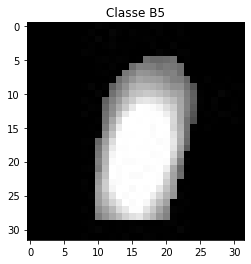

array([0., 0., 0., 1.], dtype=float32)

In [5]:
#Visualize image
plt.imshow(np.reshape((X_test[0]),(32,32)),cmap='gray')
labels = ["B2","B3","B4","B5"]
plt.title('Classe '+ labels[int(np.where(Y_test[0] == 1)[0])])
plt.show()
Y_test[0]

In [ ]:
print(X_train.shape,X_test.shape,X_val.shape)

(10969, 32, 32, 1) (1357, 32, 32, 1) (1219, 32, 32, 1)


In [6]:
#Create Model
ind = 5 #indice organizador no titulo dos checkpoints
def conv3(nfc = 64, drop_rate = .5):
  model = Sequential()
  model.add(Conv2D(64,(3,3),input_shape=(32,32,1),strides=(1,1),activation='relu'))
  model.add(Conv2D(64,(3,3),activation ='relu',strides=(1,1)))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), padding='same'))

  model.add(Conv2D(128, (3,3), activation='relu'))
  model.add(Conv2D(128, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), padding='same'))

  model.add(ZeroPadding2D((1,1)))
  model.add(Conv2D(256, (3,3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), padding='same'))


  model.add(Flatten())
  model.add(Dense(nfc,activation='relu'))
  if drop_rate != 0:
    model.add(Dropout(drop_rate))
  model.add(Dense(nfc,activation='relu'))
  if drop_rate != 0:
    model.add(Dropout(drop_rate))
  model.add(Dense(4, activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='RMSprop', metrics=['accuracy'])
  
  return model
  

In [ ]:
epoch = 200
patience = 40
batch_size = 256

# Callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

nfc = [64]

drop_rate = [.2,.4,.5]
media = 20
best_params = []
best_model = []
passos = len(nfc)*len(drop_rate)
passo = 1
for n in nfc:
  for d in drop_rate:
    print("Passo {} de {}".format(passo,passos))
    acc_list = []
    for i in range(media):
      nome_arq = 'best_model_pd2_'+ str(ind) + str(n)+'_'+str(d)+'_'+str(i)+'_.h5'
      mc = ModelCheckpoint(ROOT+"grid/conv3/"+nome_arq, monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
      model = conv3(nfc=n, drop_rate=d)
      history = model.fit(X_train,Y_train, batch_size=batch_size, epochs=epoch, validation_data=(X_val,Y_val), callbacks=[annealer,es,mc],verbose = 0)
      acc = model.evaluate(X_val, Y_val, verbose=0)
      acc_list.append(acc[1])
    acc_mean = np.mean(np.array(acc_list))
    acc_dp = np.std(np.array(acc_list))
    best_params.append([acc_mean,acc_dp,n,d])
    passo = passo + 1


Passo 1 de 3
Epoch 00059: early stopping
Epoch 00072: early stopping
Epoch 00075: early stopping
Epoch 00068: early stopping
Epoch 00070: early stopping
Epoch 00070: early stopping
Epoch 00061: early stopping
Epoch 00060: early stopping
Epoch 00063: early stopping
Epoch 00064: early stopping
Epoch 00072: early stopping
Epoch 00067: early stopping
Epoch 00066: early stopping
Epoch 00077: early stopping
Epoch 00067: early stopping
Epoch 00064: early stopping
Epoch 00072: early stopping
Epoch 00078: early stopping
Epoch 00061: early stopping
Epoch 00067: early stopping
Passo 2 de 3
Epoch 00061: early stopping
Epoch 00062: early stopping
Epoch 00066: early stopping
Epoch 00062: early stopping
Epoch 00062: early stopping
Epoch 00060: early stopping
Epoch 00071: early stopping
Epoch 00058: early stopping
Epoch 00067: early stopping
Epoch 00066: early stopping
Epoch 00070: early stopping
Epoch 00061: early stopping
Epoch 00078: early stopping
Epoch 00062: early stopping
Epoch 00069: early sto

*** Comportamento médio na validação de cada configuração***

In [ ]:
best_params 

[[0.9436833500862122, 0.006913686959259364, 64, 0.2],
 [0.9424528390169143, 0.006398029376555374, 64, 0.4],
 [0.9450779289007187, 0.004979666907090261, 64, 0.5]]

*Utilizando os melhores parâmetros*

In [17]:
# Apenas com os melhores parâmetros!!
media = 20
nfc = [64]
drop_rate = [.5]
passos = len(nfc)*len(drop_rate)
for n in nfc:
  for d in drop_rate:
    acc_list = []
    passo = 1
    acc_list_val = []
    acc_list_test = []
    acc_classe_lista = [] 
    erro_grave_list = []
    for i in range(media):
      nome_arq = 'best_model_pd2_'+ str(ind) + str(n)+'_'+str(d)+'_'+str(i)+'_.h5'
      model = load_model(ROOT+"grid/conv3/"+nome_arq)
      
      test = model.evaluate(X_test, Y_test, verbose=0)
      acc_list_test.append(test[1])
            
      y_pred = model.predict(X_test)
      y_pred = tf.argmax(y_pred, axis = 1)
      y_real = tf.argmax(Y_test, axis = 1)
      
      conf = confusion_matrix(y_true=y_real, y_pred=y_pred)
      acc_por_classe = conf.diagonal()/conf.sum(axis=1)
      acc_classe_lista.append(acc_por_classe)
      
      l1, l2, l3, l4 = confusion_matrix(y_true=y_real, y_pred=y_pred)
      erro_grave = l2[0] + sum(l3[0:2])  + sum(l4[0:3])
      erro_grave_list.append(erro_grave)  
      passo = passo + 1 


acc_classe_array = np.array(acc_classe_lista)
erro_grave_array = np.array(erro_grave_list)


acc_mean_test = np.mean(np.array(acc_list_test))
acc_dp_test = np.std(np.array(acc_list_test))

print(str(n)+'_'+str(d))

print("\nAcurácia Total Teste: média, desvio")
print([acc_mean_test.round(4),acc_dp_test.round(5)])

print("\nRecall por Classe Teste: média, desvio")
print([acc_classe_array.mean(axis=0).round(4),acc_classe_array.std(axis=0).round(5)])

print("\nErro Crítico Teste: média, desvio")
print([erro_grave_array.mean().round(4),erro_grave_array.std().round(5)])

64_0.5

Acurácia Total Teste: média, desvio
[0.9441, 0.00544]

Recall por Classe Teste: média, desvio
[array([0.9736, 0.913 , 0.9503, 0.941 ]), array([0.00662, 0.01312, 0.01035, 0.01504])]

Erro Crítico Teste: média, desvio
[40.6, 7.2208]


In [15]:
erro_grave_array # Observação de onde ocorre o menor erro crítico (escolhido quinto modelo [i=4])

array([37, 53, 40, 34, 32, 47, 38, 39, 29, 52, 35, 33, 47, 55, 42, 42, 32,
       38, 42, 45])

In [8]:
# Modelo com menor erro grave
# Apenas com os melhores parâmetros!!
nfc = [64]
drop_rate = [.5]
passos = len(nfc)*len(drop_rate)
ind = 5
i = 4 # rede com melhor desempenho
for n in nfc:
  for d in drop_rate:
    acc_list = []
    passo = 1
    acc_list_val = []
    acc_list_test = []
    acc_classe_lista = [] 
    erro_grave_list = []

    nome_arq = 'best_model_pd2_'+ str(ind) + str(n)+'_'+str(d)+'_'+str(i)+'_.h5'
    model = load_model(ROOT+"grid/conv3/"+nome_arq)
    
    test = model.evaluate(X_test, Y_test, verbose=0)
    acc_list_test.append(test[1])
          
    y_pred = model.predict(X_test)
    y_pred = tf.argmax(y_pred, axis = 1)
    y_real = tf.argmax(Y_test, axis = 1)
    
    conf = confusion_matrix(y_true=y_real, y_pred=y_pred)
    acc_por_classe = conf.diagonal()/conf.sum(axis=1)
    acc_classe_lista.append(acc_por_classe)
    
    l1, l2, l3, l4 = confusion_matrix(y_true=y_real, y_pred=y_pred)
    erro_grave = l2[0] + sum(l3[0:2])  + sum(l4[0:3])
    erro_grave_list.append(erro_grave)  
    passo = passo + 1 


acc_classe_array = np.array(acc_classe_lista)
erro_grave_array = np.array(erro_grave_list)


acc_mean_test = np.mean(np.array(acc_list_test))
acc_dp_test = np.std(np.array(acc_list_test))

print(str(n)+'_'+str(d))


print("\nAcurácia Total Teste, média")
print([acc_mean_test.round(4)])

print("\nRecall por Classe Teste, média")
print([acc_classe_array.mean(axis=0).round(4)])

print("\nErro Crítico Teste, média")
print([erro_grave_array.mean().round(4)])

64_0.5

Acurácia Total Teste, média
[0.9484]

Recall por Classe Teste, média
[array([0.9675, 0.9156, 0.9528, 0.9625])]

Erro Crítico Teste, média
[32.0]


In [9]:
nome_arq # nome do arquivo com o melhor modelo

'best_model_pd2_564_0.5_4_.h5'

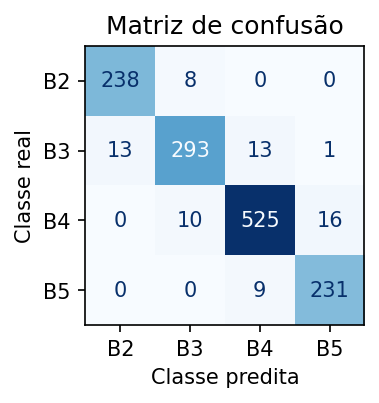

In [10]:
#One hot extraction
predictions = model.predict(X_test)
classes_pred = tf.argmax(predictions, axis = 1)
Y_test1 = tf.argmax(Y_test, axis = 1)

labels = ['B2','B3','B4','B5']
matriz_conf = confusion_matrix(y_true=Y_test1, y_pred=classes_pred)
matriz_conf = ConfusionMatrixDisplay(matriz_conf,display_labels=labels)
      
dpi = 150
figsize = (3,3)      
fig = plt.figure(dpi = dpi, figsize = figsize)
ax = fig.add_subplot(111)
matriz_conf.plot(cmap = 'Blues', ax=ax,values_format ='g')
matriz_conf.im_.colorbar.remove()
ax.set_title('Matriz de confusão');
ax.set_ylabel('Classe real')
ax.set_xlabel('Classe predita') 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()
#fig.savefig(ROOT+nome_arq+".eps")

In [11]:
from sklearn.metrics import classification_report

print(classification_report(y_true=Y_test1, y_pred=classes_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9482    0.9675    0.9577       246
           1     0.9421    0.9156    0.9287       320
           2     0.9598    0.9528    0.9563       551
           3     0.9315    0.9625    0.9467       240

    accuracy                         0.9484      1357
   macro avg     0.9454    0.9496    0.9474      1357
weighted avg     0.9485    0.9484    0.9483      1357



**Observação do treinamento de um modelo com os melhores parâmetros**


In [ ]:
del model
mc = ModelCheckpoint(ROOT+'best_model_pd2_tudo.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

model = conv3(nfc = best_params1[2], drop_rate = best_params1[3]) #64 .4
history= model.fit(X_train,Y_train, batch_size=batch_size, epochs=epoch, validation_data=(X_val,Y_val), callbacks=[annealer,es,mc])


Epoch 1/200
86/86 [==============================] - 1s 9ms/step - loss: 0.9782 - accuracy: 0.6547 - val_loss: 1.4264 - val_accuracy: 0.3733
Epoch 2/200
86/86 [==============================] - 0s 6ms/step - loss: 0.6610 - accuracy: 0.7710 - val_loss: 2.9086 - val_accuracy: 0.3626
Epoch 3/200
86/86 [==============================] - 1s 7ms/step - loss: 0.5741 - accuracy: 0.7977 - val_loss: 2.5382 - val_accuracy: 0.4192
Epoch 4/200
86/86 [==============================] - 1s 7ms/step - loss: 0.5086 - accuracy: 0.8207 - val_loss: 1.9120 - val_accuracy: 0.6563
Epoch 5/200
86/86 [==============================] - 0s 6ms/step - loss: 0.4746 - accuracy: 0.8300 - val_loss: 1.7906 - val_accuracy: 0.6218
Epoch 6/200
86/86 [==============================] - 1s 6ms/step - loss: 0.4241 - accuracy: 0.8504 - val_loss: 1.6589 - val_accuracy: 0.6981
Epoch 7/200
86/86 [==============================] - 1s 6ms/step - loss: 0.3861 - accuracy: 0.8599 - val_loss: 1.5240 - val_accuracy: 0.7268
Epoch 8/200
8

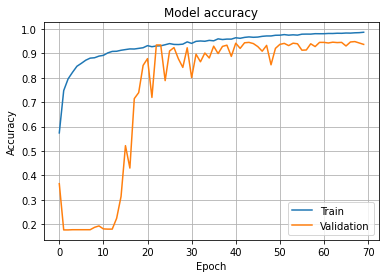

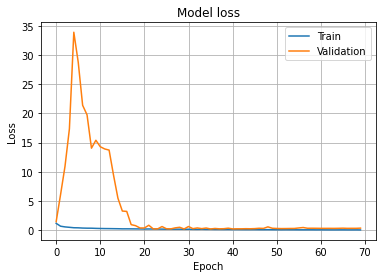

In [ ]:
# Plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.grid()
plt.show()
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.grid()
plt.show()

In [20]:
saved_model = load_model(ROOT+'best_model_pd2_tudo.h5')

In [23]:
# evaluate the model
_, train_acc = saved_model.evaluate(X_train, Y_train, verbose=0)
_, val_acc = saved_model.evaluate(X_val, Y_val, verbose=0)
_, test_acc = saved_model.evaluate(X_test, Y_test, verbose=0)
print('Train: %.3f, Val: %.3f, Test: %.3f' % (train_acc, val_acc, test_acc))


Train: 0.978, Val: 0.977, Test: 0.935
